## Some basic stuff

In [1]:
import requests
from bs4 import BeautifulSoup
from time import sleep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
def getSoup(link):
    sleep(0.1)
    r = requests.get(link)
    return BeautifulSoup(r.text,'lxml')

### Teams and their codes

#### Will be useful later on i think 

In [3]:
codes = getSoup('https://nhl.cz/sezona/tymy')

In [4]:
team_info_list = codes.findAll('a', {'class':'box-team__head'})
code_list = [x["href"] for x in team_info_list]
team_list = [h2.text for h2 in codes.findAll('h2')]
dict_team_codes = {team_list[i]: code_list[i] for i in range(len(code_list))}
dict_team_codes

{'Anaheim Ducks': '/klub/2004',
 'Arizona Coyotes': '/klub/2005',
 'Boston Bruins': '/klub/1987',
 'Buffalo Sabres': '/klub/1989',
 'Calgary Flames': '/klub/2006',
 'Carolina Hurricanes': '/klub/1990',
 'Colorado Avalanche': '/klub/2008',
 'Columbus Blue Jackets': '/klub/1991',
 'Dallas Stars': '/klub/2009',
 'Detroit Red Wings': '/klub/1992',
 'Edmonton Oilers': '/klub/2010',
 'Florida Panthers': '/klub/1993',
 'Chicago Blackhawks': '/klub/2007',
 'Los Angeles Kings': '/klub/2011',
 'Minnesota Wild': '/klub/2012',
 'Montreal Canadiens': '/klub/1994',
 'Nashville Predators': '/klub/2013',
 'New Jersey Devils': '/klub/1995',
 'New York Islanders': '/klub/1996',
 'New York Rangers': '/klub/1997',
 'Ottawa Senators': '/klub/1998',
 'Philadelphia Flyers': '/klub/1999',
 'Pittsburgh Penguins': '/klub/2000',
 'San Jose Sharks': '/klub/2014',
 'Seattle Kraken': '/klub/2730',
 'St. Louis Blues': '/klub/2015',
 'Tampa Bay Lightning': '/klub/2001',
 'Toronto Maple Leafs': '/klub/2002',
 'Vancouv

In [5]:
#sezony zatim rucne neprijde mi ze by to slo od nekud vycist
#2017 je 2017/2018 atd.
season_codes = {'2017': '6049', '2018': '6270', '2019': '6494', '2020': '6673','2021': '6733'}
seasons_used = ['2017', '2018', '2019', '2020','2021']

In [6]:
distinct_teams = list(dict_team_codes.keys())

## How it works: one team and one season so far

#### TOI = Team of Interest

In [7]:
team_of_interest = "Boston Bruins"
code_of_interest = dict_team_codes[team_of_interest]
season_of_interest = '2021'
code_of_season = season_codes[season_of_interest]
soup = getSoup(f'https://nhl.cz{code_of_interest}/zapasy?matchList-filter-season={season_of_interest}&matchList-filter-competition={code_of_season}')
#soup

In [8]:
all_games = soup.findAll('tr')

### Goals in a list

In [9]:
goals = [int(td.text) for td in soup.findAll('td', {'class':'preview__score'})]
goals[:5]

[3, 1, 6, 3, 1]

### Teams in a list

In [10]:
teams = [span.text for span in soup.findAll('span', {'class':'preview__name--long'})]
teams[:5]

['Boston Bruins',
 'Dallas Stars',
 'Philadelphia Flyers',
 'Boston Bruins',
 'Buffalo Sabres']

### Overtime or not

In [11]:
OT = []
for game in all_games:
    ot = game.find('span', {'class':'dot dot__blue'})
    if ot is None:
        OT.append(0)
    else:
        OT.append(1)
print(OT[:7])

[0, 0, 0, 0, 0, 0, 1]


### Game ID in a list

In [12]:
game_ids_list = soup.find_all("a", href=lambda value: value and value.startswith("/zapas/"))
game_ids = [x["href"] for x in game_ids_list][::2]
game_ids[:5]

['/zapas/2897006',
 '/zapas/2897032',
 '/zapas/2897045',
 '/zapas/2897063',
 '/zapas/2897081']

### Putting it in a dataframe

In [13]:
aux_dictionary = {'game_id':game_ids, 'team_home': teams[::2], 'team_away': teams[1::2],
    'goals_home': goals[::2], 'goals_away': goals[1::2], 'OT': OT} 
df = pd.DataFrame(aux_dictionary)
df.head()

,game_id,team_home,team_away,goals_home,goals_away,OT
0,/zapas/2897006,Boston Bruins,Dallas Stars,3,1,0
1,/zapas/2897032,Philadelphia Flyers,Boston Bruins,6,3,0
2,/zapas/2897045,Buffalo Sabres,Boston Bruins,1,4,0
3,/zapas/2897063,Boston Bruins,San Jose Sharks,4,3,0
4,/zapas/2897081,Florida Panthers,Boston Bruins,4,1,0


### Adding some more variables that might be useful

In [14]:
df.loc[(df["goals_home"] > df["goals_away"]) & (df["OT"] == 0), 'points_home'] = 3
df.loc[(df["goals_home"] > df["goals_away"]) & (df["OT"] == 1), 'points_home'] = 2
df.loc[(df["goals_home"] < df["goals_away"]) & (df["OT"] == 1), 'points_home'] = 1
df.loc[(df["goals_home"] < df["goals_away"]) & (df["OT"] == 0), 'points_home'] = 0

df.loc[(df["goals_home"] > df["goals_away"]) & (df["OT"] == 0), 'points_away'] = 0
df.loc[(df["goals_home"] > df["goals_away"]) & (df["OT"] == 1), 'points_away'] = 1
df.loc[(df["goals_home"] < df["goals_away"]) & (df["OT"] == 1), 'points_away'] = 2
df.loc[(df["goals_home"] < df["goals_away"]) & (df["OT"] == 0), 'points_away'] = 3

df.head()

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,points_away
0,/zapas/2897006,Boston Bruins,Dallas Stars,3,1,0,3.0,0.0
1,/zapas/2897032,Philadelphia Flyers,Boston Bruins,6,3,0,3.0,0.0
2,/zapas/2897045,Buffalo Sabres,Boston Bruins,1,4,0,0.0,3.0
3,/zapas/2897063,Boston Bruins,San Jose Sharks,4,3,0,3.0,0.0
4,/zapas/2897081,Florida Panthers,Boston Bruins,4,1,0,3.0,0.0


### Adding variable whether the team of interest is a home team

In [15]:
df.loc[df["team_home"] == team_of_interest, 'TOI_home'] = 1
df.loc[df["team_home"] != team_of_interest, 'TOI_home'] = 0

### Adding how many points TOI received

In [16]:
df.loc[(df["TOI_home"] == 1), 'TOI_points'] = df["points_home"]
df.loc[(df["TOI_home"] == 0), 'TOI_points'] = df["points_away"]

df.loc[(df["TOI_home"] == 1), 'TOI_goals_scored'] = df["goals_home"]
df.loc[(df["TOI_home"] == 0), 'TOI_goals_scored'] = df["goals_away"]
df.loc[(df["TOI_home"] == 1), 'TOI_goals_rec'] = df["goals_away"]
df.loc[(df["TOI_home"] == 0), 'TOI_goals_rec'] = df["goals_home"]

### Adding Output Variable: the result of our TOI

In [17]:
df.loc[df["OT"] == 1, 'TOI_result'] = "OT"
df.loc[(df["TOI_home"] == 1) & (df["points_home"] == 3), 'TOI_result'] = "W"
df.loc[(df["TOI_home"] == 1) & (df["points_home"] == 0), 'TOI_result'] = "L"
df.loc[(df["TOI_home"] == 0) & (df["points_home"] == 3), 'TOI_result'] = "L"
df.loc[(df["TOI_home"] == 0) & (df["points_home"] == 0), 'TOI_result'] = "W"
#later only W/L is used for better performance

In [18]:
df.loc[(df["TOI_home"] == 1), 'other_team'] = df["team_away"]
df.loc[(df["TOI_home"] == 0), 'other_team'] = df["team_home"]
df.head()

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,points_away,TOI_home,TOI_points,TOI_goals_scored,TOI_goals_rec,TOI_result,other_team
0,/zapas/2897006,Boston Bruins,Dallas Stars,3,1,0,3.0,0.0,1.0,3.0,3.0,1.0,W,Dallas Stars
1,/zapas/2897032,Philadelphia Flyers,Boston Bruins,6,3,0,3.0,0.0,0.0,0.0,3.0,6.0,L,Philadelphia Flyers
2,/zapas/2897045,Buffalo Sabres,Boston Bruins,1,4,0,0.0,3.0,0.0,3.0,4.0,1.0,W,Buffalo Sabres
3,/zapas/2897063,Boston Bruins,San Jose Sharks,4,3,0,3.0,0.0,1.0,3.0,4.0,3.0,W,San Jose Sharks
4,/zapas/2897081,Florida Panthers,Boston Bruins,4,1,0,3.0,0.0,0.0,0.0,1.0,4.0,L,Florida Panthers


### Adding variables - sum of last 20 games

In [19]:
TOI_points_tot = [None] * 20
TOI_goals_scored_tot = [None] * 20
TOI_goals_rec_tot = [None] * 20
for x in range(len(df)):
    if x > 19:
        TOI_points_tot.append(int(df[['TOI_points']][x-20:x].sum()))
        TOI_goals_scored_tot.append(int(df[['TOI_goals_scored']][x-20:x].sum()))
        TOI_goals_rec_tot.append(int(df[['TOI_goals_rec']][x-20:x].sum()))
df['TOI_points_tot'] = TOI_points_tot
df['TOI_goals_scored_tot'] = TOI_goals_scored_tot
df['TOI_goals_rec_tot'] = TOI_goals_rec_tot

df.iloc[19:25, 8:]

,TOI_home,TOI_points,TOI_goals_scored,TOI_goals_rec,TOI_result,other_team,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot
19,0.0,3.0,2.0,0.0,W,Nashville Predators,NaN,NaN,NaN
20,1.0,1.0,2.0,3.0,OT,Tampa Bay Lightning,35.0,59.0,53.0
21,0.0,1.0,1.0,2.0,OT,Vancouver Canucks,33.0,58.0,55.0
22,0.0,3.0,3.0,2.0,W,Edmonton Oilers,34.0,56.0,51.0
23,0.0,3.0,4.0,2.0,W,Calgary Flames,34.0,55.0,52.0
24,1.0,0.0,1.0,4.0,L,Vegas Golden Knights,34.0,55.0,51.0


Takhle bude vypadat df, akorat v nim bude dat za vice sezon

## Creating the dataset later used for modellig

## ke kazdemu zapasu: 
- jeho id
- nazev druheho tymu
- vysledek TOI (output variable)
- jestli hraje TOI doma
- kolik ziskal TOI bodu v poslednich X (20/30) zapasech
- kolik dal TOI golu v poslednich X (20/30) zapasech
- kolik dostal TOI golu v poslednich X (20/30) zapasech

  
    - toto bude jeste vse potreba i pro druhy tym s kterym je prave ten zapas
    - tyhle radky plus radky o druhem tymu by uz meli jit nakrmit do modelu a to by melo byt vsechno

In [20]:
df_model = df[['game_id','TOI_result','other_team','TOI_home', 'TOI_points_tot', 'TOI_goals_scored_tot', 'TOI_goals_rec_tot']][20:].copy()
df_model

,game_id,TOI_result,other_team,TOI_home,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot
20,/zapas/2897351,OT,Tampa Bay Lightning,1.0,35.0,59.0,53.0
21,/zapas/2897379,OT,Vancouver Canucks,0.0,33.0,58.0,55.0
22,/zapas/2897387,W,Edmonton Oilers,0.0,34.0,56.0,51.0
23,/zapas/2897403,W,Calgary Flames,0.0,34.0,55.0,52.0
24,/zapas/2897426,L,Vegas Golden Knights,1.0,34.0,55.0,51.0
...,...,...,...,...,...,...,...
77,/zapas/2898234,W,New York Rangers,1.0,34.0,63.0,54.0
78,/zapas/2897458,W,Montreal Canadiens,0.0,34.0,62.0,52.0
79,/zapas/2898259,W,Florida Panthers,1.0,34.0,64.0,53.0
80,/zapas/2898274,W,Buffalo Sabres,1.0,35.0,66.0,54.0


# Turning it into OOP

In [21]:
class One_team_season:
   
    def __init__(self,team, season):
        self.team = team
        self.season = season
        
    def get_link(self):
        code_of_season = season_codes[self.season]
        code_of_interest = dict_team_codes[self.team]
        return f'https://nhl.cz{code_of_interest}/zapasy?matchList-filter-season={self.season}&matchList-filter-competition={code_of_season}'
    
    def get_soup(self):
        r = requests.get(self.get_link())
        if r.status_code == 200:
            r.encoding='UTF-8'
            return BeautifulSoup(r.text)
        else:
            raise Exception(f'Cannot access the url. Returning status_code {r.status_code}')
            
    def get_goals(self,soup):
        return [int(td.text) for td in soup.findAll('td', {'class':'preview__score'})]
    
    def get_teams(self,soup):
        return [span.text for span in soup.findAll('span', {'class':'preview__name--long'})]
    
    def get_OT(self,soup):
        all_games = soup.findAll('tr')
        OT = []
        for game in all_games:
            ot = game.find('span', {'class':'dot dot__blue'})
            if ot is None:
                OT.append(0)
            else:
                OT.append(1)
        return OT
    
    def get_game_IDs(self,soup):
        game_ids_list = soup.find_all("a", href=lambda value: value and value.startswith("/zapas/"))
        game_ids = [x["href"] for x in game_ids_list][::2]
        return game_ids
    
    def create_df(self):
        soup = self.get_soup()
        goals = self.get_goals(soup)
        teams = self.get_teams(soup)
        OT = self.get_OT(soup)
        game_ids = self.get_game_IDs(soup)
        
        #covid vsuvka - apparently games cancelled due to covid were left blank and would cause errors
        if len(goals)/2 == len(teams)/2 == len(OT) == len(game_ids):
            pass
        else:
            teams = teams[:len(goals)]
            OT = OT[:int(len(goals)/2)]
            game_ids = game_ids[:int(len(goals)/2)]
        #konec covid vsuvky

        
        aux_dictionary = {'game_id':game_ids, 'team_home': teams[::2], 'team_away': teams[1::2],
        'goals_home': goals[::2], 'goals_away': goals[1::2], 'OT': OT} 
        df = pd.DataFrame(aux_dictionary)
        return df
    
    def create_model_df(self):
        df = self.create_df()
        df.loc[(df["goals_home"] > df["goals_away"]) & (df["OT"] == 0), 'points_home'] = 3
        df.loc[(df["goals_home"] > df["goals_away"]) & (df["OT"] == 1), 'points_home'] = 2
        df.loc[(df["goals_home"] < df["goals_away"]) & (df["OT"] == 1), 'points_home'] = 1
        df.loc[(df["goals_home"] < df["goals_away"]) & (df["OT"] == 0), 'points_home'] = 0

        df.loc[(df["goals_home"] > df["goals_away"]) & (df["OT"] == 0), 'points_away'] = 0
        df.loc[(df["goals_home"] > df["goals_away"]) & (df["OT"] == 1), 'points_away'] = 1
        df.loc[(df["goals_home"] < df["goals_away"]) & (df["OT"] == 1), 'points_away'] = 2
        df.loc[(df["goals_home"] < df["goals_away"]) & (df["OT"] == 0), 'points_away'] = 3
        
        df.loc[df["team_home"] == self.team, 'TOI_home'] = 1
        df.loc[df["team_home"] != self.team, 'TOI_home'] = 0
        
        df.loc[(df["TOI_home"] == 1), 'TOI_points'] = df["points_home"]
        df.loc[(df["TOI_home"] == 0), 'TOI_points'] = df["points_away"]

        df.loc[(df["TOI_home"] == 1), 'TOI_goals_scored'] = df["goals_home"]
        df.loc[(df["TOI_home"] == 0), 'TOI_goals_scored'] = df["goals_away"]
        df.loc[(df["TOI_home"] == 1), 'TOI_goals_rec'] = df["goals_away"]
        df.loc[(df["TOI_home"] == 0), 'TOI_goals_rec'] = df["goals_home"]
        
        
        df.loc[(df["TOI_home"] == 1) & (df["points_home"] > df["points_away"]), 'TOI_result'] = 1 #1 is a win
        df.loc[(df["TOI_home"] == 1) & (df["points_home"] < df["points_away"]), 'TOI_result'] = 0
        df.loc[(df["TOI_home"] == 0) & (df["points_home"] > df["points_away"]), 'TOI_result'] = 0
        df.loc[(df["TOI_home"] == 0) & (df["points_home"] < df["points_away"]), 'TOI_result'] = 1
        
        df.loc[(df["TOI_home"] == 1), 'other_team'] = df["team_away"]
        df.loc[(df["TOI_home"] == 0), 'other_team'] = df["team_home"]
        
        df.loc[(df["TOI_home"] == 1), 'TOI'] = df["team_home"]
        df.loc[(df["TOI_home"] == 0), 'TOI'] = df["team_away"]
        
        return df


    

## Joining DataFrames for multiple seasons

In [22]:
#this scrapes a lot of data - it takes about 2 minutes
individual_teams = []
for team in distinct_teams:
    one_team = []
    for season in seasons_used:
        one_team.append(One_team_season(team, season).create_model_df())
    one_team = pd.concat(one_team, ignore_index=True)
    individual_teams.append(one_team)

individual_teams[1] #looks promising

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,points_away,TOI_home,TOI_points,TOI_goals_scored,TOI_goals_rec,TOI_result,other_team,TOI
0,/zapas/2526065,Anaheim Ducks,Arizona Coyotes,5,4,0,3.0,0.0,0.0,0.0,4.0,5.0,0.0,Anaheim Ducks,Arizona Coyotes
1,/zapas/2526080,Arizona Coyotes,Vegas Golden Knights,1,2,1,1.0,2.0,1.0,1.0,1.0,2.0,0.0,Vegas Golden Knights,Arizona Coyotes
2,/zapas/2526099,Vegas Golden Knights,Arizona Coyotes,5,2,0,3.0,0.0,0.0,0.0,2.0,5.0,0.0,Vegas Golden Knights,Arizona Coyotes
3,/zapas/2526110,Arizona Coyotes,Detroit Red Wings,2,4,0,0.0,3.0,1.0,0.0,2.0,4.0,0.0,Detroit Red Wings,Arizona Coyotes
4,/zapas/2526126,Arizona Coyotes,Boston Bruins,2,6,0,0.0,3.0,1.0,0.0,2.0,6.0,0.0,Boston Bruins,Arizona Coyotes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,/zapas/2898225,Arizona Coyotes,Washington Capitals,0,2,0,0.0,3.0,1.0,0.0,0.0,2.0,0.0,Washington Capitals,Arizona Coyotes
368,/zapas/2898229,Arizona Coyotes,St. Louis Blues,4,5,1,1.0,2.0,1.0,1.0,4.0,5.0,0.0,St. Louis Blues,Arizona Coyotes
369,/zapas/2898258,Minnesota Wild,Arizona Coyotes,3,5,0,0.0,3.0,0.0,3.0,5.0,3.0,1.0,Minnesota Wild,Arizona Coyotes
370,/zapas/2898269,Dallas Stars,Arizona Coyotes,3,4,1,1.0,2.0,0.0,2.0,4.0,3.0,1.0,Dallas Stars,Arizona Coyotes


In [23]:
#this calculates the data for last 20 games which we use for our model
def create_final_df(df):
    TOI_points_tot = [None] * 20
    TOI_goals_scored_tot = [None] * 20
    TOI_goals_rec_tot = [None] * 20
    for x in range(len(df)):
        if x > 19:
            TOI_points_tot.append(int(df[['TOI_points']][x-20:x].sum()))
            TOI_goals_scored_tot.append(int(df[['TOI_goals_scored']][x-20:x].sum()))
            TOI_goals_rec_tot.append(int(df[['TOI_goals_rec']][x-20:x].sum()))
    df['TOI_points_tot'] = TOI_points_tot
    df['TOI_goals_scored_tot'] = TOI_goals_scored_tot
    df['TOI_goals_rec_tot'] = TOI_goals_rec_tot
    return df[['game_id', 'TOI_result', 'TOI_home','TOI', 'other_team', 'TOI_points_tot',
               'TOI_goals_scored_tot', 'TOI_goals_rec_tot']][20:]

In [24]:
#dataframe containing last 20 games data for each game of each team
final_dfs = []
for team in individual_teams:
    final = create_final_df(team)
    final_dfs.append(final)

In [25]:
final_dfs[14].head()

,game_id,TOI_result,TOI_home,TOI,other_team,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot
20,/zapas/2526373,1.0,0.0,Minnesota Wild,Buffalo Sabres,30.0,59.0,55.0
21,/zapas/2526390,1.0,1.0,Minnesota Wild,Colorado Avalanche,33.0,62.0,55.0
22,/zapas/2526409,0.0,0.0,Minnesota Wild,St. Louis Blues,34.0,61.0,52.0
23,/zapas/2526419,0.0,0.0,Minnesota Wild,Winnipeg Jets,31.0,59.0,56.0
24,/zapas/2526438,1.0,1.0,Minnesota Wild,Vegas Golden Knights,30.0,57.0,58.0


## Choosing two teams and building the model

In [26]:
team_1 = "Vegas Golden Knights"
team_2 = "Winnipeg Jets"

In [27]:
team_1_index = distinct_teams.index(team_1)
team_2_index = distinct_teams.index(team_2)

In [28]:
matches_team_1 = final_dfs[team_1_index]
matches_team_1

,game_id,TOI_result,TOI_home,TOI,other_team,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot
20,/zapas/2526401,1.0,1.0,Vegas Golden Knights,San Jose Sharks,37.0,72.0,60.0
21,/zapas/2526408,1.0,0.0,Vegas Golden Knights,Arizona Coyotes,36.0,75.0,63.0
22,/zapas/2526430,0.0,1.0,Vegas Golden Knights,Dallas Stars,37.0,77.0,64.0
23,/zapas/2526438,0.0,0.0,Vegas Golden Knights,Minnesota Wild,34.0,72.0,65.0
24,/zapas/2526448,0.0,0.0,Vegas Golden Knights,Winnipeg Jets,34.0,71.0,63.0
...,...,...,...,...,...,...,...,...
368,/zapas/2898210,1.0,1.0,Vegas Golden Knights,Washington Capitals,26.0,62.0,62.0
369,/zapas/2898241,0.0,1.0,Vegas Golden Knights,San Jose Sharks,28.0,65.0,63.0
370,/zapas/2898257,0.0,0.0,Vegas Golden Knights,Dallas Stars,29.0,68.0,65.0
371,/zapas/2898268,0.0,0.0,Vegas Golden Knights,Chicago Blackhawks,30.0,68.0,63.0


### Adding info about other team to the df

In [29]:
other_team_points_tot = []
other_team_goals_scored_tot = []
other_team_goals_rec_tot = []
for observation in range(len(matches_team_1)):
    other_team = matches_team_1.iat[observation,4]
    other_team_index = distinct_teams.index(other_team)
    other_team_df = final_dfs[other_team_index]
    game_id = matches_team_1.iat[observation,0]
    radek = other_team_df.loc[other_team_df['game_id'] == game_id]
    if radek.empty: #it is possible that the other team has not played 20 games yet
        other_team_points_tot.append(np.nan)
        other_team_goals_scored_tot.append(np.nan)
        other_team_goals_rec_tot.append(np.nan)
    else:
        other_team_points_tot.append(radek.iat[0,5])
        other_team_goals_scored_tot.append(radek.iat[0,6])
        other_team_goals_rec_tot.append(radek.iat[0,7])

In [30]:
matches_team_1['other_team_points_tot'] = other_team_points_tot
matches_team_1['other_team_goals_scored_tot'] = other_team_goals_scored_tot
matches_team_1['other_team_goals_rec_tot'] = other_team_goals_rec_tot
matches_team_1 = matches_team_1.dropna()

In [31]:
#transforming to integers and dropping unnecessary columns
matches_team_1[['TOI_result','TOI_home']] = matches_team_1[['TOI_result','TOI_home']].astype(int)
matches_team_1 = matches_team_1.drop(columns=['game_id', 'TOI','other_team'])

#### Defining the independent and dependent variables

In [32]:
#independent
x = matches_team_1.iloc[:, 1:].values
#dependent - the result
y = matches_team_1.iloc[:, 0].values

#### Splitting into training and test set

In [33]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

In [34]:
X_test[:5]

array([[ 1., 31., 70., 67., 26., 54., 63.],
       [ 0., 34., 68., 54., 28., 62., 68.],
       [ 0., 39., 78., 60., 21., 54., 71.],
       [ 1., 42., 69., 52., 28., 55., 52.],
       [ 1., 29., 64., 57., 35., 71., 61.]])

In [35]:
#rescaling everything except the "home" dummy ... and then adding the dummy back
scaler = StandardScaler()
X_train_stand = scaler.fit_transform(X_train[:,1:])
X_test_stand = scaler.transform(X_test[:,1:])
X_train_stand = np.insert(X_train_stand,0,X_train[:,0],axis=1)
X_test_stand = np.insert(X_test_stand,0,X_test[:,0],axis=1)

#### The model and predictions

In [36]:
reg = LogisticRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [37]:
#how well does the model perform?
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[ 3 13]
 [ 1 19]]


In [38]:
print("Accuracy :  \n", accuracy_score(y_test, y_pred))

Accuracy :  
 0.6111111111111112


In [50]:
matches_team_2 = final_dfs[team_2_index]
matches_team_2

,game_id,TOI_result,TOI_home,TOI,other_team,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot
20,/zapas/2526387,1.0,0.0,Winnipeg Jets,Los Angeles Kings,38.0,67.0,56.0
21,/zapas/2526389,1.0,0.0,Winnipeg Jets,Anaheim Ducks,41.0,67.0,50.0
22,/zapas/2526410,0.0,0.0,Winnipeg Jets,San Jose Sharks,44.0,68.0,45.0
23,/zapas/2526419,1.0,1.0,Winnipeg Jets,Minnesota Wild,41.0,63.0,47.0
24,/zapas/2526434,0.0,0.0,Winnipeg Jets,Colorado Avalanche,41.0,66.0,47.0
...,...,...,...,...,...,...,...,...
368,/zapas/2898224,0.0,0.0,Winnipeg Jets,Carolina Hurricanes,27.0,61.0,70.0
369,/zapas/2898244,1.0,1.0,Winnipeg Jets,Colorado Avalanche,24.0,61.0,73.0
370,/zapas/2898270,1.0,1.0,Winnipeg Jets,Philadelphia Flyers,27.0,63.0,69.0
371,/zapas/2898285,1.0,1.0,Winnipeg Jets,Calgary Flames,28.0,63.0,66.0


### the final prediction

In [40]:
#je to v poradi points-goals scored-goals received
pred_team_1 = individual_teams[team_1_index][['TOI_points', 'TOI_goals_scored', 'TOI_goals_rec']].tail(20).sum().values
pred_team_1

array([34., 71., 58.])

In [41]:
pred_team_2 = individual_teams[team_2_index][['TOI_points', 'TOI_goals_scored', 'TOI_goals_rec']].tail(20).sum().values
pred_team_2

array([31., 61., 63.])

In [42]:
TOI_home = np.array([1])

In [43]:
values_to_fit = np.concatenate([TOI_home, pred_team_1, pred_team_2]).reshape(1, -1)

In [44]:
final_pred = reg.predict(values_to_fit)
final_pred

array([1])

In [45]:
if final_pred[0] == 1:
    print('The team', team_1, "is predicted to win this game.")
elif final_pred[0] == 0:
    print('The team', team_2, "is predicted to win this game.")
else:
    print('An error occured along the way. Please try again.')

The team Vegas Golden Knights is predicted to win this game.


### Calculating Home Advantage

In [46]:
sum_wins_home = sum(df["goals_home"] > df["goals_away"])
sum_wins_away = sum(df["goals_home"] < df["goals_away"])
 
home_winrate = sum_wins_home/(sum_wins_home+sum_wins_away)
home_winrate


0.5121951219512195

### After picking 2 teams both their final_dfs are found, saved and displayed

In [47]:
matches_between_them = matches_team_1.merge(matches_team_2, left_on='game_id', right_on='game_id',suffixes=('', '2'))
matches_between_them.drop(columns=['TOI_result2', 'TOI_home2','TOI2','other_team2','TOI_points_tot2','TOI_goals_scored_tot2','TOI_goals_rec_tot2'], inplace=True)
pd.set_option("display.max_rows", None, "display.max_columns", None)
matches_between_them


KeyError: 'game_id'

In [132]:
pd.set_option("display.max_rows", 15, "display.max_columns", 15) #just so we dont display so many rows next time


In [49]:
matches_between_them_ids = matches_between_them['game_id']
matches_between_them_ids

NameError: name 'matches_between_them' is not defined

### Graphs

In [120]:
import matplotlib.pyplot as plt # pak hodit nahoru k ostatním importům
import seaborn as sns # pak hodit nahoru k ostatním importům
matches_team_1_graphs = individual_teams[team_1_index]
matches_team_2_graphs = individual_teams[team_2_index]
matches_team_1_graphs['match_ordr'] = range(1, len(matches_team_1_graphs) + 1)
matches_team_2_graphs['match_ordr'] = range(1, len(matches_team_2_graphs) + 1)
type(matches_team_2_graphs)
matches_team_2_graphs

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,...,TOI_goals_scored,TOI_goals_rec,TOI_result,other_team,TOI,index,match_ordr
0,/zapas/2526055,Winnipeg Jets,Toronto Maple Leafs,2,7,0,0.0,...,2.0,7.0,0.0,Toronto Maple Leafs,Winnipeg Jets,1,1
1,/zapas/2526083,Calgary Flames,Winnipeg Jets,6,3,0,3.0,...,3.0,6.0,0.0,Calgary Flames,Winnipeg Jets,2,2
2,/zapas/2526091,Edmonton Oilers,Winnipeg Jets,2,5,0,0.0,...,5.0,2.0,1.0,Edmonton Oilers,Winnipeg Jets,3,3
3,/zapas/2526109,Vancouver Canucks,Winnipeg Jets,2,4,0,0.0,...,4.0,2.0,1.0,Vancouver Canucks,Winnipeg Jets,4,4
4,/zapas/2526117,Winnipeg Jets,Carolina Hurricanes,2,1,0,3.0,...,2.0,1.0,1.0,Carolina Hurricanes,Winnipeg Jets,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,/zapas/2898224,Carolina Hurricanes,Winnipeg Jets,4,2,0,3.0,...,2.0,4.0,0.0,Carolina Hurricanes,Winnipeg Jets,369,369
369,/zapas/2898244,Winnipeg Jets,Colorado Avalanche,4,1,0,3.0,...,4.0,1.0,1.0,Colorado Avalanche,Winnipeg Jets,370,370
370,/zapas/2898270,Winnipeg Jets,Philadelphia Flyers,4,0,0,3.0,...,4.0,0.0,1.0,Philadelphia Flyers,Winnipeg Jets,371,371
371,/zapas/2898285,Winnipeg Jets,Calgary Flames,3,1,0,3.0,...,3.0,1.0,1.0,Calgary Flames,Winnipeg Jets,372,372


### Merge both teams into one dataframe

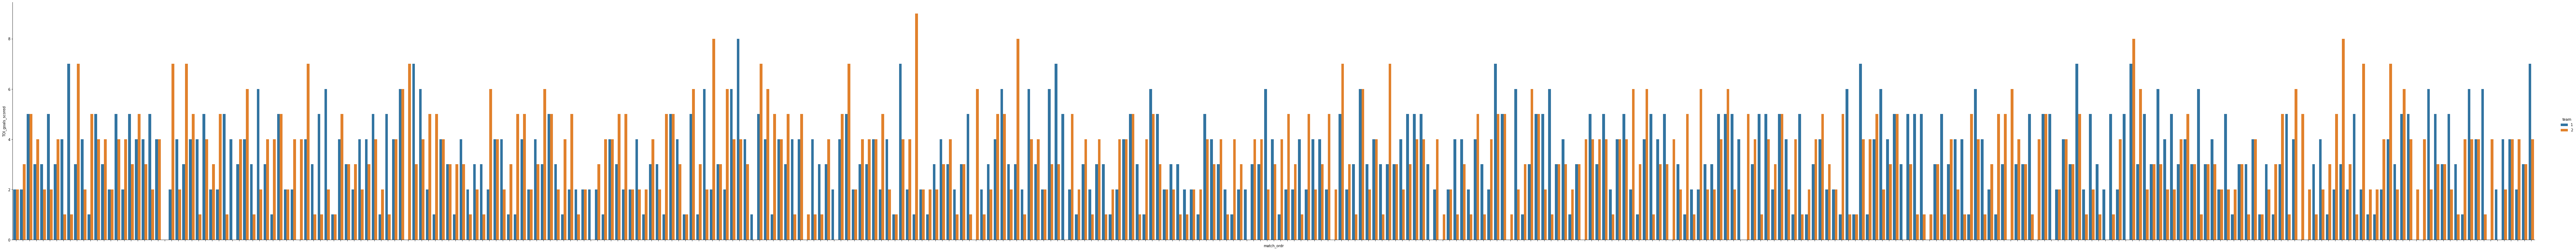

In [124]:
graphs = pd.concat([matches_team_1_graphs, matches_team_2_graphs], axis=0, ignore_index=False)
graphs['team'] = (len(matches_team_1_graphs)*(1,) + len(matches_team_2_graphs)*(2,))
graph_1 = sns.catplot(x='match_ordr', y='TOI_goals_scored', hue='team', kind='bar', data=graphs, height=10, aspect=10)
graph_1.set(xticklabels=[])
graph_1
# too many matches we need to cut the data we are ploting


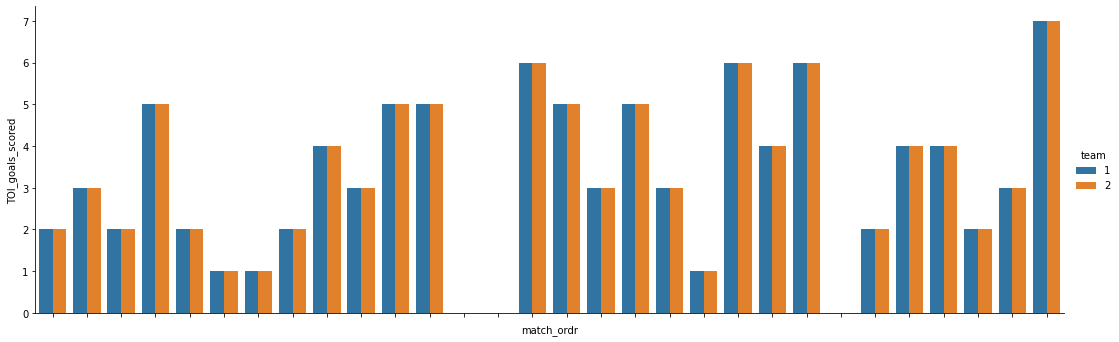

In [129]:
matches_team_1_graphs_30 = matches_team_1_graphs.tail(30)
matches_team_2_graphs_30 = matches_team_1_graphs.tail(30)
graphs_30 = pd.concat([matches_team_1_graphs_30, matches_team_2_graphs_30], axis=0, ignore_index=False)
graphs_30['team'] = (len(matches_team_1_graphs_30)*(1,) + len(matches_team_2_graphs_30)*(2,))
graphs_30
graph_2 = sns.catplot(x='match_ordr', y='TOI_goals_scored', hue='team', kind='bar', data=graphs_30, height=5, aspect=3)
graph_2.set(xticklabels=[])
graph_2

### Kolik bodů získal tým celkem

In [ ]:
#tady je problem že je to zatím pro jeden tým určený tím boston.
#Až budem vyjíždět týmy je třeba upravit
toi=boston.create_model_df()
points_home = toi.groupby(['team_home'])['points_home'].sum().reset_index()
points_away = toi.groupby(['team_away'])['points_away'].sum().reset_index()
points_home.rename(columns = {'team_home':'team'}, inplace = True)
points_away.rename(columns = {'team_away':'team'}, inplace = True)
tp = points_home.merge(points_away, left_on='team', right_on='team')
total_poins = tp["points_home"] + tp["points_away"]
tp["points_total"] = points_total
tp.drop(tp[tp.points_total < 15].index, inplace=True)
if len(tp) != 1:
            raise Exception('There is more than 1 team left')
tp

In [ ]:
if len(tp) != 1:
            raise Exception('There is more than 1 team left')
